<a href="https://colab.research.google.com/github/nikhilnimmagadda/HousingPriceClassification-/blob/master/Copy_of_Deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split 
from keras.initializers import RandomNormal
from keras.layers import Dense, Input, Reshape, Dropout, ZeroPadding2D
from sklearn.preprocessing import MultiLabelBinarizer , LabelEncoder
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df2 = pd.read_csv('/content/drive/My Drive/HLA_peptide_allele_tissue.tsv',delimiter='\t')
# np.random.seed(1337)
noise_dim = 50
batch_size = 128
output_dim= 36
epochs = 100
optimizer = Adam(0.0002, 0.5)
df2

,peptide_sequence_id,peptide_sequence,tissue_name,hla_type_class,hla_type_name,predicted_affinity
0,7079,FSRFLNKQPY,Kidney,class1,B*35:01,weak
1,10038,ALFDGDPHL,Adrenal Gland,class1,C*03:04,weak
2,3248,KQYERSIVDY,Lung,class1,B*15:01,strong
3,1888,YQTAISENY,Uterus,class1,B*35:01,weak
4,12356,YYIRETENF,Heart,class1,C*06:02,weak
...,...,...,...,...,...,...
449400,30904,GEWDKALSI,Spleen,class1,B*49:01,strong
449401,7850,YFRDQEGQDV,Bone Marrow,class1,C*04:01,strong
449402,50046,KPPKPVSKMRMATPLLMQALP,Tongue,class2,DQA1*01:02-DQB1*03:03,weak
449403,50046,KPPKPVSKMRMATPLLMQALP,Esophagus,class2,DRB4*01:01,strong


In [0]:
encoder_tissue = LabelEncoder()
train_tissue = df2['tissue_name']
print(train_tissue)
train_tissue = encoder_tissue.fit_transform(train_tissue)
train_tissue = train_tissue.reshape((train_tissue.shape[0], 1))
print(train_tissue.shape)
print(encoder_tissue.inverse_transform(train_tissue))

# train_x_2.describe()
# encoder.inverse_transform(train_x_2[:100])
# train_x_2

0                Kidney
1         Adrenal Gland
2                  Lung
3                Uterus
4                 Heart
              ...      
449400           Spleen
449401      Bone Marrow
449402           Tongue
449403        Esophagus
449404             Lung
Name: tissue_name, Length: 449405, dtype: object
(449405, 1)
['Kidney' 'Adrenal Gland' 'Lung' ... 'Tongue' 'Esophagus' 'Lung']


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:273: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
encoder_class = LabelBinarizer()
#encoder_class = MultiLabelBinarizer()
train_class = df2['hla_type_class']
train_class = encoder_class.fit_transform(train_class)
train_class.shape

(449405, 1)

In [0]:
encoder_name = LabelEncoder()
train_name = df2['hla_type_name']
train_name = encoder_name.fit_transform(train_name)
print(train_name.shape)
train_name = train_name.reshape((train_name.shape[0], 1))
train_name.shape


(449405,)


(449405, 1)

In [0]:
encoder_affinity = LabelBinarizer()
train_affinity = df2['predicted_affinity']
train_affinity = encoder_affinity.fit_transform(train_affinity)


In [0]:
train_sequence = df2['peptide_sequence']

tokenizer = Tokenizer(lower=False, char_level=True)
tokenizer.fit_on_texts(train_sequence)

train_sequence = tokenizer.texts_to_sequences(train_sequence)
train_sequence = pad_sequences(train_sequence, maxlen=32)
# max(list(map(len, train_sequence)))

# np.amax(train_sequence)


In [0]:




print(train_sequence.shape)
print(train_tissue.shape)
print(train_class.shape)
print(train_name.shape)
print(train_affinity.shape)


(449405, 32)
(449405, 1)
(449405, 1)
(449405, 1)
(449405, 1)


In [0]:
train_x = np.concatenate((train_sequence, 
                          train_tissue, 
                          train_class, 
                          train_name, 
                          train_affinity), 
                         axis=1)

In [0]:
train_x.shape

(449405, 36)

In [0]:
def create_generator(noise_dim, out_dim):
    generator = Sequential()

    generator.add(Dense(256,input_dim = noise_dim))
    generator.add(LeakyReLU(0.2));

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2));

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(out_dim))
    generator.add(LeakyReLU(0.2))

    generator.compile(loss='binary_crossentropy',
                      optimizer = optimizer)

    return generator

In [0]:
def create_descriminator(input_dimension):
    discriminator = Sequential()
     
    discriminator.add(Dense(1024, input_dim=input_dimension))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', 
                          optimizer=optimizer, 
                          metrics=['accuracy'])
    return discriminator

In [0]:
 

discriminator = create_descriminator(output_dim)
generator = create_generator(noise_dim, output_dim)

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_sequence = generator(gan_input)

gan_output = discriminator(fake_sequence)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [0]:
# Display images, and save them if the epoch number is specified
def show_images():
    noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
    generated_images = generator.predict(noise)
    
    
    for i, image in enumerate(generated_images):
        image = tokenizer.sequences_to_texts(train_x)
        print(image)


In [0]:

# batches = train_x.shape[0] / batch_size
temp1 = []
temp2 = []
for epoch in range(epochs):

    for batch in range(100):
        
        for _ in range(2):
          noise = np.random.normal(0, 1, size=(batch_size, noise_dim))

          real_x = train_x[np.random.randint(0, train_x.shape[0], size=batch_size)]
          fake_x = generator.predict(noise)

          x = np.concatenate((real_x, fake_x))

          disc_y = np.zeros(2*batch_size)
          disc_y[:batch_size] = 0.95



          d_loss =  discriminator.train_on_batch(x, disc_y)
          temp1.append(d_loss)
          
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)
        temp2.append(g_loss)
    #print(f'Epoch: {epoch}')
    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    #if epoch % 10 == 0:
        #show_images()
generator.save('/content/drive/My Drive/generator.h5')
gan.save('/content/drive/My Drive/gan.h5')
discriminator.save('/content/drive/My Drive/discriminator.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 	 Discriminator Loss: [0.6357504, 0.5] 		 Generator Loss: [0.45103425, 0.96875]
Epoch: 1 	 Discriminator Loss: [0.4226547, 0.4140625] 		 Generator Loss: [2.4709024, 0.0]
Epoch: 2 	 Discriminator Loss: [0.514073, 0.38671875] 		 Generator Loss: [1.4708796, 0.0390625]
Epoch: 3 	 Discriminator Loss: [0.61421746, 0.3359375] 		 Generator Loss: [1.340828, 0.03125]
Epoch: 4 	 Discriminator Loss: [0.49331886, 0.484375] 		 Generator Loss: [1.251114, 0.0703125]
Epoch: 5 	 Discriminator Loss: [0.6571279, 0.40234375] 		 Generator Loss: [1.181814, 0.0546875]
Epoch: 6 	 Discriminator Loss: [0.54387474, 0.40625] 		 Generator Loss: [1.1039739, 0.109375]
Epoch: 7 	 Discriminator Loss: [0.64540017, 0.4765625] 		 Generator Loss: [1.077713, 0.0703125]
Epoch: 8 	 Discriminator Loss: [0.55688685, 0.4765625] 		 Generator Loss: [1.0580943, 0.140625]
Epoch: 9 	 Discriminator Loss: [0.604462, 0.4453125] 		 Generator Loss: [1.4002272, 0.015625]
Epoch: 10 	 Discriminator Loss: [0.5916715, 0.44140625] 		 G

In [0]:
loaded_model = load_model('/content/drive/My Drive/generator.h5')

In [0]:
type(loaded_model)

keras.engine.sequential.Sequential

In [195]:
peptide_num = 10000
noise = np.random.normal(0, 1, size=(peptide_num, noise_dim))
#generated_sequence = generator.predict(noise)
generated_sequence = loaded_model.predict(noise)
print(generated_sequence)
generated_sequence = generated_sequence.astype(int)
"""
inverse_transform(train_x_2[:100])
train_x = np.concatenate((train_sequence, 
                          train_tissue, 
                          train_class, 
                          train_name, 
                          train_affinity), 
                         axis=1)
encoder_class, encoder_name, encoder_affinity, encoder_tissue
peptide_sequence	tissue_name	hla_type_class	hla_type_name	predicted_affinity
(449405, 32)
(449405, 30)
(449405, 1)
(449405, 81)
(449405, 1)
"""
generated_sequence

[[-3.38795818e-02 -7.82624725e-03 -3.54274176e-02 ... -3.26820798e-02
   5.04157352e+00  1.57815486e-01]
 [ 3.22668761e-01 -6.32940158e-02 -3.35984342e-02 ... -5.78089319e-02
   1.28941250e+00 -8.52002725e-02]
 [-1.20188091e-02 -5.56885544e-03 -6.63344339e-02 ...  8.08310583e-02
   9.65443802e+00 -3.27691436e-02]
 ...
 [ 2.06978973e-02  1.39833778e-01 -7.31972032e-05 ... -3.14140208e-02
   1.67829590e+01  2.32528836e-01]
 [-4.49083187e-03 -5.58325164e-02 -1.07207716e-01 ...  2.67779604e-02
   2.03215599e+01 -9.74493399e-02]
 [ 7.53371567e-02  1.15811795e-01 -3.84633057e-02 ... -3.84168490e-03
   2.37496643e+01  2.67435640e-01]]


array([[ 0,  0,  0, ...,  0,  5,  0],
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  0,  9,  0],
       ...,
       [ 0,  0,  0, ...,  0, 16,  0],
       [ 0,  0,  0, ...,  0, 20,  0],
       [ 0,  0,  0, ...,  0, 23,  0]])

In [0]:
generated_sequence[2]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  3, 13,  4, 12, 14,  2,  2,  3,  5, 13,  0,
       29,  0])

array([[ 0,  0,  0, ...,  0, 16,  0],
       [ 0,  0,  0, ...,  0,  7,  0],
       [ 0,  0,  0, ...,  0, 25,  0],
       ...,
       [ 0,  0,  0, ...,  0,  3,  0],
       [ 0,  0,  0, ...,  0, 19,  0],
       [ 0,  0,  0, ...,  1, 59,  0]])

In [196]:
a = train_sequence.shape[1]
b = a + train_tissue.shape[1]
c = b + train_class.shape[1]
d = c + train_name.shape[1]
e = d + train_affinity.shape[1]

#print(generated_sequence[0][a:b])
result = []
for i in range(peptide_num):

  try:
    generated_text = tokenizer.sequences_to_texts([generated_sequence[i][:a]])[0]
    tissue = encoder_tissue.inverse_transform(generated_sequence[i][a:b].reshape(b-a, 1))[0]
    type_class = encoder_class.inverse_transform(generated_sequence[i][b:c].reshape(c-b, 1))[0]
    type_name = encoder_name.inverse_transform(generated_sequence[i][c:d].reshape(d-c,1))[0]
    affinity = encoder_affinity.inverse_transform(generated_sequence[i][d:].reshape(e-d,1))[0]
  
    print({
        'peptide_sequence':generated_text,
        'tissue_name':tissue,
        'hla_type_class':type_class,
        'hla_type_name':type_name,
        'predicted_affinity':affinity
    })
    my_details = {
        'peptide_sequence':generated_text,
        'tissue_name':tissue,
        'hla_type_class':type_class,
        'hla_type_name':type_name,
        'predicted_affinity':affinity
    }
    result.append(my_details)
  except:
    continue

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:273: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'peptide_sequence': 'F I E L D L V E I', 'tissue_name': 'Small Intestine', 'hla_type_class': 'class1', 'hla_type_name': 'A*23:01', 'predicted_affinity': 'strong'}
{'peptide_sequence': 'T L T F A D T N L', 'tissue_name': 'Mamma', 'hla_type_class': 'class1', 'hla_type_name': 'A*02:01', 'predicted_affinity': 'strong'}
{'peptide_sequence': 'P T I V R S F L P', 'tissue_name': 'Aorta', 'hla_type_class': 'class1', 'hla_type_name': 'A*68:01', 'predicted_affinity': 'strong'}
{'peptide_sequence': 'C T I Y L L R T', 'tissue_name': 'Spleen', 'hla_type_class': 'class1', 'hla_type_name': 'B*35:01', 'predicted_affinity': 'strong'}
{'peptide_sequence': 'F V P V L D T L', 'tissue_name': 'Cerebellum', 'hla_type_class': 'class1', 'hla_type_name': 'A*69:01', 'predicted_affinity': 'strong'}
{'peptide_sequence': 'E F A P Y A Y P L', 'tissue_name': 'Colon', 'hla_type_class': 'class1', 'hla_type_name': 'B*58:01', 'predicted_affinity': 'strong'}
{'peptide_sequence': 'A F A L L L H V L', 'tissue_name': 'Spleen

(9866, 5)


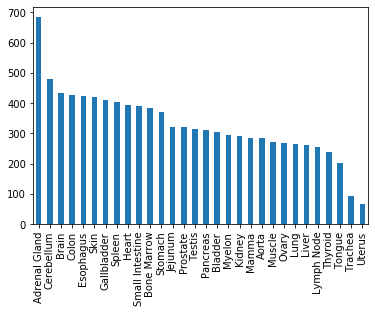

In [253]:
#Observation2:Plot of number of tissues count for the generated tissue count
result_data =  pd.DataFrame(result)
print(result_data.shape)
result_tissue_name = result_data['tissue_name']
result_tissue_pandas = pd.DataFrame(result_tissue_name)
visual = result_tissue_pandas['tissue_name'].value_counts().plot(kind='bar')

#visual
#visual.hist()
#plt.ylabel('Frequency')
#plt.xlabel('Tissue')
#plt.title('Histogram')
#result_data

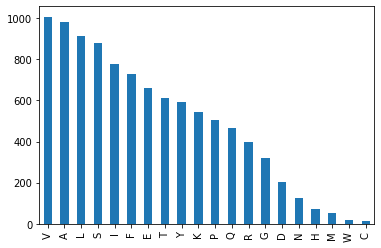

In [248]:
#Observation2:Highest starting character for the peptide generated sequence 
result_peptide = result_data['peptide_sequence']
result_data['extra'] = result_data['peptide_sequence'].astype(str).str[0]
visual2 = result_data['extra'].value_counts().plot(kind='bar')

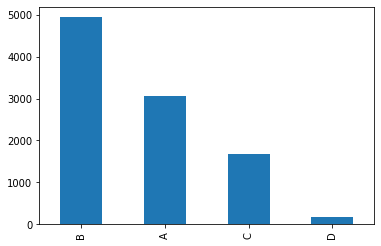

In [252]:
#Observation3:Most repeating hla type classes produced for generated peptides
result_hlatype = result_data['hla_type_name']
result_data['extra2'] = result_data['hla_type_name'].astype(str).str[0] #+ #result_data['hla_type_name'].astype(str).str[1]
result_data['extra2']
visual3 = result_data['extra2'].value_counts().plot(kind='bar')

In [247]:
result_data

,peptide_sequence,tissue_name,hla_type_class,hla_type_name,predicted_affinity,extra
0,F I E L D L V E I,Small Intestine,class1,A*23:01,strong,F
1,T L T F A D T N L,Mamma,class1,A*02:01,strong,T
2,P T I V R S F L P,Aorta,class1,A*68:01,strong,P
3,C T I Y L L R T,Spleen,class1,B*35:01,strong,C
4,F V P V L D T L,Cerebellum,class1,A*69:01,strong,F
...,...,...,...,...,...,...
9861,P L F Q A L I T L,Adrenal Gland,class1,B*37:01,strong,P
9862,P Q L Y L A Y K L K,Tongue,class1,A*02:05,strong,P
9863,L I S L P L L Y E,Brain,class1,B*15:01,strong,L
9864,S F S G R E N K L,Gallbladder,class1,B*35:08,strong,S


In [155]:
import json
with open('/content/drive/My Drive/test1.txt', 'w') as f:
    f.write(json.dumps(result))
#with open('/content/drive/My Drive/listfile.json', 'wb') as filehandle:
    # store the data as binary data stream
    #pickle.dump(result, filehandle)

TypeError: ignored